# EP2 - Conjunto de Maldelbrot e paralelização com CUDA e OMPI

| Nome | NUSP |
|------|------|
| Giulia C. de Nardi | 10692203 |
| Vitor D. Tamae | 10705620 |
| Lucy Anne de Omena Evangelista | 11221776 |
| Leonardo Costa Santos | 10783142 |
| Alexandre Muller Jones | 8038149 |

Caso não queira rodar novamente os experimentos, **por favor pular para a sessão "Lendo dados"**.

## Configuração do ambiente

Atualizando os pacotes Julia

In [1]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %38.6 %Fetching: [=========================>               ]  61.4 %Fetching: [===================================>     ]  87.1 % Resolving package versions...
 Installed NaNMath ──── v0.3.4
 Installed FillArrays ─ v0.8.13
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [1a297f60] ↑ FillArrays v0.8.12 ⇒ v0.8.13
  [77ba4419] ↑ NaNMath v0.3.3 ⇒ v0.3.4


Verificando o status dos pacotes, e se há algum problema, com o comando:

In [2]:
] st

    Status `~/.julia/environments/v1.3/Project.toml`
  [336ed68f] CSV v0.7.3
  [a93c6f00] DataFrames v0.21.4
  [31c24e10] Distributions v0.23.4
  [7073ff75] IJulia v1.21.2
  [b964fa9f] LaTeXStrings v1.1.0
  [8314cec4] PGFPlotsX v1.2.8
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6
  [10745b16] Statistics 


Chamando pacotes que usaremos:

In [3]:
using DataFrames, Query, StatsPlots, Statistics

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


## Verificando compilação pelo notebook

In [4]:
; make mandelbrot_cuda

make: 'mandelbrot_cuda' is up to date.


In [5]:
; ./mandelbrot_cuda

usage: ./mandelbrot_seq c_x_min c_x_max c_y_min c_y_max image_size
examples with image_size = 11500:
    Full Picture:         ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500
    Seahorse Valley:      ./mandelbrot_seq -0.8 -0.7 0.05 0.15 11500
    Elephant Valley:      ./mandelbrot_seq 0.175 0.375 -0.1 0.1 11500
    Triple Spiral Valley: ./mandelbrot_seq  


In [6]:
; ./mandelbrot_cuda 0.175 0.375 -0.1 0.1 200 2 2

0.141048,0.549999


## Funções para realização dos experimentos

A função abaixo recebe parâmetros:

- `mandel`, com o nome da função a ser executada (`./mandelbrot_seq`, `./mandelbrot_opm`, `./mandelbrot_pth`, `./mandelbrot_ompi` ou `./mandelbrot_cuda`);
- `thread`, com o número de threads do programa paralelo, caso a implementacao seja em pthreads ou OpenMP;
- `process`, com a quantidade de processos para a implementação em OMPI;
- `grid` e `bloco`, com a dimensão do grid e quantidade de blocos para a implementação em CUDA.

A função executa o programa `mandelbrot` com os parâmetros dados e devolve um `DataFrame` com os resultados.

In [7]:
function measure_mandelbrot(mandel; thread = 0, process = 0, grid = 0, bloco = 0)    
    
    # para este EP só serao feitas comparacoes usando a regiao triple spiral
    mode = `-0.188 -0.012 0.554 0.754` #triple spiral
    size = 4096
    
    if thread != 0       # PThreads e OpenMP
        if process != 0
            results = parse.(Float64, #OpenMP + OMPI
                split(chomp(read(`mpirun --hostfile hostfile -np $process ./$mandel $mode $size $thread `, String)), ","))
        else
            results = parse.(Float64,
                split(chomp(read(`./$mandel $mode $size $thread `, String)), ","))
        end
        
    else
        
        if process != 0  # OMPI
            results = parse.(Float64, 
                        split(chomp(read(`mpirun -n $process ./$mandel $mode $size `, String)), ","))
        else
            
            if grid != 0 # CUDA
                println(grid,bloco)
                results = parse.(Float64,
                        split(chomp(read(`./$mandel $mode $size $grid $bloco `, String)), ","))
            
            else         # Sequencial
                results = parse.(Float64,
                    split(chomp(read(`./$mandel $mode $size`, String)), ","))
            end  
        end 
    end
    
    return DataFrame(
        threads = thread,
        processes = process,
        griddim = grid,
        blocos = bloco,
        duration = results[1],
        io_alocation = results[2])
end

measure_mandelbrot (generic function with 1 method)

A função `run_experiments` recebe os mesmos parâmetros `mandel`, `threads`, `process`, `grid` e `bloco` e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento. A função devolve um `DataFrame` com todos os experimentos.

In [8]:
function run_experiments(mandel, repetitions; threads = [], process = [], grid = [], bloco = [])
    run(`make $mandel`)
        
    results = DataFrame(
        threads = Int[],
        processes = Int[],
        griddim = Int[],
        blocos = Int[],
        duration = Float64[],
        io_alocation = Float64[]) 
    
    if threads != [] # Implementação em OpenMP ou PThreads
        if process == []
            for t in threads
                for r in 1:repetitions
                    append!(results,
                        measure_mandelbrot(mandel, thread = t))    
                end
            end
            else #OpenMP utilizando OMPI
            for p in process
                println("process", p)
                for t in threads
                    println("threads", t)
                    for r in 1: repetitions
                        println("rep", r)
                        append!(results,
                        measure_mandelbrot(mandel, thread = t, process = p))
                    end
                end
            end
        end
    else
    
        if process != [] # Implementação em OMPI
            
            for p in process
                println("process",p)
                for r in 1:repetitions
                    println("rep",r)
                    append!(results,
                        measure_mandelbrot(mandel, process = p))    
                end
            end 
        else
            if grid != [] # Implementação em CUDA
                println("Started")
                for g in grid
                    println("grid: ",g)
                    for b in bloco
                        println("bloco: ",b)
                        for r in 1:repetitions
                            println("rep: ",r)
                            append!(results,
                                measure_mandelbrot(mandel, grid = g, bloco  = b))    
                        end
                    end
                end 
                
            else 
                # Implementação sequencial
                for r in 1:repetitions
                    for s in size
                        append!(results,
                            measure_mandelbrot(mandel))    
                    end
                end
            end
        end
    end
    
    return results
end

run_experiments (generic function with 1 method)

A função `parse_results` recebe um `DataFrame` de resultados, produzido pela função `run_experiments`. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% dos tempos de execução, agrupados por número de threads, processos, dimensao do grid e quantidade de blocos.

In [9]:
function parse_results(results)
    parsed_results = results |>
                    @groupby({_.threads, _.processes,_.griddim,_.blocos}) |>
                    @map({threads = key(_).threads,
                          processes = key(_).processes,
                          griddim = key(_).griddim,
                          blocos = key(_).blocos,  
                          mean_duration = mean(_.duration),
                          mean_io_alocation = mean(_.io_alocation),
                          ci_duration = 1.96 * std(_.duration),
                          ci_io_alocation = 1.96 * std(_.io_alocation)}) |>
                    DataFrame
    
    return parsed_results
end

parse_results (generic function with 1 method)

## Funções para traçar gráficos

A função abaixo permite que sejam traçadas até 5 séries de dados em um mesmo gráfico do tipo scatter.

In [54]:
pgfplotsx()

function plot_results(x, y, series_label, yerror; x2 = x, y2 = [], series_label2 = [], yerror2 = [], title = "",
        xaxis = "Threads", min_thread_power = 0, max_thread_power = 5, recursive = 0, ompi = 0, ompi2 = 0)
    
    if recursive == 1
        values = [2 ^ x for x in min_thread_power:max_thread_power];
        p = scatter(xaxis = :log2, xlabel = xaxis,
            xticks = [2 ^ x for x in min_thread_power:max_thread_power],title = title)
        
        if ompi == 0
        for v in values
            p = scatter!(filter(row -> row[:blocos] == v, x).griddim,
            filter(row -> row[:blocos] == v, x).mean_duration, 
            yerror = filter(row -> row[:blocos] == v, x).ci_duration,
            xaxis = :log2, xlabel = xaxis,
            xticks = [2 ^ x for x in min_thread_power:max_thread_power],
             alpha = 0.6, labels = "$v x $v threads por bloco", legend = :best)
        
        end 
        else
            if ompi2 == 0
            for v in values
                p = scatter!(filter(row -> row[:processes] == v, x).threads,
                filter(row -> row[:processes] == v, x).mean_duration, 
                yerror = filter(row -> row[:processes] == v, x).ci_duration,
                xaxis = :log2, xlabel = xaxis,
                xticks = [2 ^ x for x in min_thread_power:max_thread_power],
                alpha = 0.6, labels = "$v processos", legend = :best)
            end
            else 
            for v in values
                p = scatter!(filter(row -> row[:threads] == v, x).processes,
                filter(row -> row[:threads] == v, x).mean_duration, 
                yerror = filter(row -> row[:threads] == v, x).ci_duration,
                xaxis = :log2, xlabel = xaxis,
                xticks = [2 ^ x for x in min_thread_power:max_thread_power],
                alpha = 0.6, labels = "$v threads", legend = :best)
            end
            end
        end
    
    else
    
        p = scatter(x, y, xaxis = :log2, xlabel = xaxis, xticks = [2 ^ x for x in min_thread_power:max_thread_power],
        yerror = yerror, alpha = 0.6, 
        labels = series_label, legend = :best, title = title)
    
    
    
        if y2 != []
        p = scatter!(x2, y2, xaxis = :log2, xticks = [2 ^ x for x in min_thread_power:max_thread_power],
            yerror = yerror2, alpha = 0.6,
            labels = series_label2, legend = :best)
        end
    end
    
    return p
end

plot_results (generic function with 1 method)

## Condições para os experimentos

O tamanho da imagem em 4096 e a região como sendo a Triple Spiral Valley estão definidas internamente nas funções.

In [11]:
repetitions = 15;

size = [2^12];
grids = [2 ^ x for x in 3:4];      # CUDA
blocos = [2^x for x in 3:4];       # CUDA
thread =  [2 ^ x for x in 0:5];    # OpenMP e PThreads
processes = [2 ^ x for x in 1:6];  # OMPI

# Sobre as implementações em CUDA e OMPI

## CUDA

Na implementação em CUDA, foi utilizado um grid onde são especfiicados $n$ e $m$, onde o grid terá dimensão de $n \times n$ blocos e cada bloco terá $m \times m$ threads. O número de tarefas (cáculo do número de iterações de uma posição) é calculado de acordo com o número de threads disponíveis. Se o número total de threads for maior do que o número de tarefas, cada thread recebe uma tarefa para ser feita e uma parte fica ociosa. Se o número total de threads for menor, cada thread calculará o número de iterações de sua posição e de seus vizinhos, aumentando o número de vizinhos calculados de acordo com a razão número de tarefas por número de threads.

É esperado que caso as dimensões do grid e do bloco sejam pequenas demais, o programa se aproxime da implementação sequencial, pois o programa estará sendo menos paralelizado. Por outro lado, se as dimensões especificadas forem grandes demais, o número de threads sem tarefas será alto e o manejamento delas será um processo desnecessário em execução.

Para definir as escolhas de valores para a dimensão do grid e de blocos, vamos de uma thread e bloco, sendo uma implementação basicamente sequencial, até $2^5 \times 2^5$ blocos com até $2^5 \times 2^5$ para observar também o efeito da paralelização excessiva no CUDA, ou seja, com menos de uma tarefa disponível por thread ocorrendo ociosidade.

## OMPI

A implementação do OMPI foi feita utilizando alocação dinâmica de tarefas. Diferentemente do CUDA, temos um limite bem menor de processos que podem ser utilizados. Portanto, tem maior cabimento uma implementação parecida com a de pThreads, onde cada processo se responsabiliza por uma linha inteira da matriz image_buffer, na intenção de não saturar o processo raiz. Este por sua vez (implementada no rank 0) é responsável por administrar os outros processos e assinalar as tarefas. O processo raiz primeiro irá se certificar de que todos os processos estejam trabalhando assinalando novos trabalhos àqueles que estiverem ociosos e logo após esperará que algum deles envie sua resposta calculada. Nesse momento, o processo raiz registra a resposta recebida no image_buffer e sinaliza que tal processo se tornou ocioso. A ação se repete até que todas as respostas sejam registradas no image_buffer.

Para a implementação feita não é possível executar o programa com apenas um processo. É interessante notar que o programa executará infinitamente sem terminar a tarefa, pois haverá apenas o processo raiz administrando outros processos, que nesse caso são inexistentes, o que fará com que o programa congele. De fato isso pode ser considerado uma desvantagem, porém, do ponto de vista de implementação, a alocação dinâmica de trabalho gera muitos benefícios para valores maiores (e mais usuais) de processos, pois há a garantia de que não haverão processos ociosos continuamente.

Utilizamos os parâmetros de acordo com o enunciado, porém, devido à particularidade do nosso programa de não poder executar com um único processo, ao invés disso testamos com dois processos.


# Gerando e Salvando dados

## Mandelbrot sequencial

Realizando as medições para o mandelbrot sequencial:

In [ ]:
results_seq_triplespiral = run_experiments("mandelbrot_seq", repetitions);
seq_triplespiral = parse_results(results_seq_triplespiral);

## Mandelbrot com pthreads

Realizando as medições para o mandelbrot com PThreads:

In [ ]:
results_pth_triplespiral = run_experiments("mandelbrot_pth", repetitions, threads=thread);
pth_triplespiral = parse_results(results_pth_triplespiral);

## Mandelbrot com OpenMP

Realizando as medições para o mandelbrot com OpenMP:

In [ ]:
results_omp_triplespiral = run_experiments("mandelbrot_omp", repetitions, threads=thread);
omp_triplespiral = parse_results(results_omp_triplespiral);

## Mandelbrot com OMPI

Realizando as medições para o mandelbrot com OMPI:

In [ ]:
results_ompi_triplespiral = run_experiments("mandelbrot_ompi", repetitions, process=processes);
ompi_triplespiral = parse_results(results_ompi_triplespiral);

## Mandelbrot com CUDA

Realizando as medições para o mandelbrot com CUDA:

In [ ]:
results_cuda_triplespiral = run_experiments("mandelbrot_cuda", repetitions, grid = grids, bloco = blocos)
cuda_triplespiral = parse_results(results_cuda_triplespiral)

## Mandelbrot com OMPI e OpenMP

Realizando as medições para o mandelbrot com OMPI e OMP:

In [ ]:
results_ompi_omp_triplespiral = run_experiments("mandelbrot_ompi_omp", repetitions, grid = grids, bloco = blocos)
ompi_omp_triplespiral = parse_results(results_ompi_omp_triplespiral)

## Salvando dados

In [ ]:
using CSV

function save_csv_results(results,filename)
    println(filename)
    CSV.write(filename, results)
end

In [ ]:
save_csv_results(results_seq_triplespiral,"data/results_seq_triplespiral.csv");
save_csv_results(seq_triplespiral,"data/seq_triplespiral.csv");

In [ ]:
save_csv_results(results_omp_triplespiral,"data/results_omp_triplespiral.csv");
save_csv_results(omp_triplespiral,"data/omp_triplespiral.csv");

In [ ]:
save_csv_results(results_pth_triplespiral,"data/results_pth_triplespiral.csv");
save_csv_results(pth_triplespiral,"data/pth_triplespiral.csv");

In [ ]:
save_csv_results(results_ompi_triplespiral,"data/results_ompi_triplespiral.csv");
save_csv_results(ompi_triplespiral,"data/ompi_triplespiral.csv");

In [ ]:
save_csv_results(results_cuda_triplespiral,"data/results_cuda_triplespiral.csv");
save_csv_results(cuda_triplespiral,"data/cuda_triplespiral.csv");

In [ ]:
save_csv_results(results_ompi_omp_triplespiral,"data/results_ompi_omp_triplespiral.csv");
save_csv_results(ompi_omp_triplespiral,"data/ompi_omp_triplespiral.csv");

# Lendo dados

In [12]:
using CSV

function read_csv_results(filename)
    results=CSV.read(filename)
    return results
end

read_csv_results (generic function with 1 method)

Os gráficos iniciados por "results" são aqueles que não possuem suas informações agregadas (como média e intervalo de confiança). Carregando os dataframes gerados, para testes futuros:

In [13]:
seq_triplespiral=read_csv_results("data/seq_triplespiral.csv");
omp_triplespiral=read_csv_results("data/omp_triplespiral.csv");
pth_triplespiral=read_csv_results("data/pth_triplespiral.csv");
ompi_triplespiral=read_csv_results("data/ompi_triplespiral.csv");
cuda_triplespiral=read_csv_results("data/cuda_triplespiral.csv");
ompi_omp_triplespiral=read_csv_results("data/ompi_omp_triplespiral.csv");

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40


In [14]:
results_seq_triplespiral=read_csv_results("data/results_seq_triplespiral.csv");
results_omp_triplespiral=read_csv_results("data/results_omp_triplespiral.csv");
results_pth_triplespiral=read_csv_results("data/results_pth_triplespiral.csv");
results_ompi_triplespiral=read_csv_results("data/results_ompi_triplespiral.csv");
results_cuda_triplespiral=read_csv_results("data/results_cuda_triplespiral.csv");
results_ompi_omp_triplespiral=read_csv_results("data/results_ompi_omp_triplespiral.csv");

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40


# Comparando desempenho 

## Sequencial

In [15]:
seq_triplespiral

,threads,processes,griddim,blocos,mean_duration,mean_io_alocation,ci_duration
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,0,0,0,0,22.8507,23.4183,2.84466


Vemos que o tempo do algoritmo sequencial executa em aproximadamente 23 segundos, o que utilizaremos como marca para comparar com os resultados da paralelização.

## OpenMP

In [16]:
omp_triplespiral

,threads,processes,griddim,blocos,mean_duration,mean_io_alocation,ci_duration
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1,0,0,0,24.2683,24.8182,5.85721
2,2,0,0,0,13.597,14.2058,3.97046
3,4,0,0,0,7.47859,8.01289,1.7702
4,8,0,0,0,4.71604,5.28662,0.424891
5,16,0,0,0,4.57927,5.16605,0.474447
6,32,0,0,0,4.64606,5.22027,0.470139


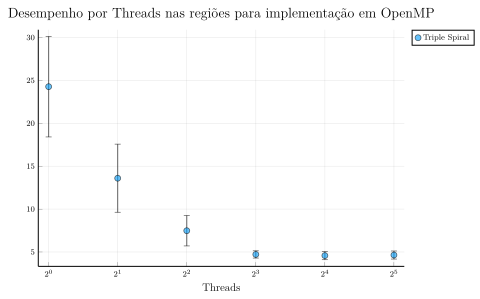

In [17]:
plot_results(omp_triplespiral.threads, omp_triplespiral.mean_duration, "Triple Spiral",
    omp_triplespiral.ci_duration,
    title = "Desempenho por Threads nas regiões para implementação em OpenMP", max_thread_power = 5)

Com a implementação do mandelbrot com o OpenMP. Podemos observar uma melhora considerável no tempo de execução. Também percebemos que o tempo de execução converge para aproximadamente 5 segundos, com $2^3$ threads ou mais.

Com isso, podemos afirmar que a melhor quantidade de threads para a implementação com OpenMP é de 8 threads, por utilizar menos recursos computacionais e ainda obtendo o tempo de execução ótimo.

## PThreads

In [18]:
pth_triplespiral

,threads,processes,griddim,blocos,mean_duration,mean_io_alocation,ci_duration
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1,0,0,0,21.6387,22.2595,4.12705
2,2,0,0,0,11.835,12.4012,1.39972
3,4,0,0,0,6.37354,6.85628,0.70408
4,8,0,0,0,4.5561,5.09227,0.40529
5,16,0,0,0,4.80984,5.41049,0.615975
6,32,0,0,0,4.84709,5.43311,0.561177


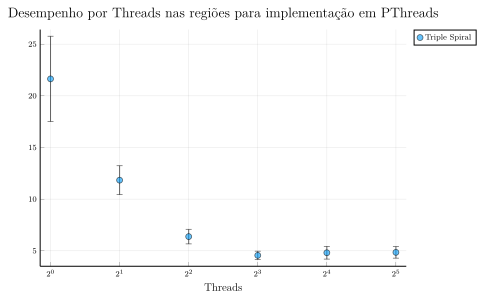

In [19]:
plot_results(pth_triplespiral.threads, pth_triplespiral.mean_duration, "Triple Spiral",
    pth_triplespiral.ci_duration,
    title = "Desempenho por Threads nas regiões para implementação em PThreads", max_thread_power = 5)

Obtemos resultados similares à implementação com OpenMP, também obtendo valor ótimo com o uso de $2^3$ threads, e com tempo de execução de cerca de 4.5 segundos.

## OMPI

In [20]:
ompi_triplespiral

,threads,processes,griddim,blocos,mean_duration,mean_io_alocation,ci_duration
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,0,2,0,0,23.9692,24.682,0.176358
2,0,4,0,0,9.74403,10.4945,0.237506
3,0,8,0,0,10.4214,11.7664,3.84695
4,0,16,0,0,12.3236,15.3467,3.12606
5,0,32,0,0,11.2501,17.122,1.19614
6,0,64,0,0,11.6354,23.2792,0.911987


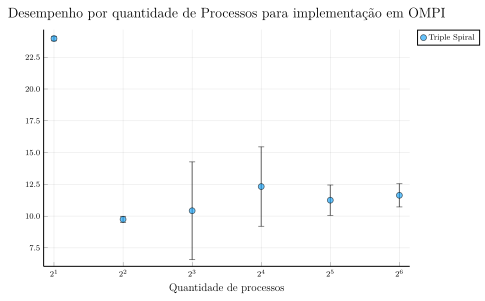

In [21]:
plot_results(ompi_triplespiral.processes, ompi_triplespiral.mean_duration, "Triple Spiral", 
    ompi_triplespiral.ci_duration,
    title = "Desempenho por quantidade de Processos para implementação em OMPI",
    xaxis = "Quantidade de processos", max_thread_power = 6)

Vemos que o primeiro ponto, com 2 processos, obtém tempo de execução muito acima dos outros. Isso ocorre porque só há um processo realizando a tarefa de cálculos para o mandelbrot, sendo a outra responsável pelo gerenciamento. Justamente por isso, seu tempo de execução é muito próximo do tempo de execução da implementação sequencial. Lembrando que, pelo mesmo motivo, não testamos o algoritmo com um processo pela inexistência de processos trabalhadores nesse caso, de acordo com a nossa implementação.

Mostrando o desempenho usando o OMPI desconsiderando o primeiro ponto, de dois processos, para comparar melhor os outros:

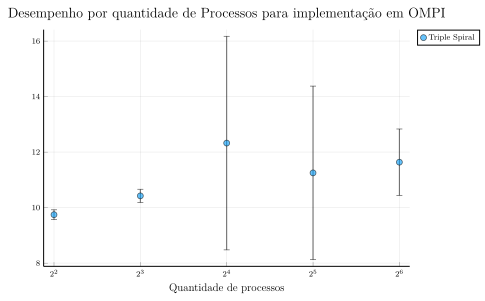

In [22]:
plot_results(filter(row -> row[:processes] > 2, ompi_triplespiral).processes,
    filter(row -> row[:processes] > 2, ompi_triplespiral).mean_duration, "Triple Spiral", 
    ompi_triplespiral.ci_duration, title = "Desempenho por quantidade de Processos para implementação em OMPI",
    xaxis = "Quantidade de processos", max_thread_power = 6)

Vericamos que obtemos o melhor resultado para o OMPI com 4 processos, por obter uma menor média para o tempo de execução (pouco abaixo de 10 segundos), e um menor intervalo de confiança, considerando uma melhor estabilidade dos resultados. A implementação com 4 processos utiliza menos recursos computacionais e ainda obtendo o tempo de execução ótimo.

Entretanto, o seu tempo de execução ótimo está acima dos valores obtidos com a implementação em PThreads e OpenMP, sendo praticamente o dobro.


## CUDA

In [23]:
show(cuda_triplespiral, allrows=true)

36×8 DataFrame. Omitted printing of 3 columns
│ Row │ threads │ processes │ griddim │ blocos │ mean_duration │
│     │ Int64   │ Int64     │ Int64   │ Int64  │ Float64       │
├─────┼─────────┼───────────┼─────────┼────────┼───────────────┤
│ 1   │ 0       │ 0         │ 1       │ 1      │ 500.155       │
│ 2   │ 0       │ 0         │ 1       │ 2      │ 137.326       │
│ 3   │ 0       │ 0         │ 1       │ 4      │ 34.6314       │
│ 4   │ 0       │ 0         │ 1       │ 8      │ 9.6373        │
│ 5   │ 0       │ 0         │ 1       │ 16     │ 4.01391       │
│ 6   │ 0       │ 0         │ 1       │ 32     │ 4.00061       │
│ 7   │ 0       │ 0         │ 2       │ 1      │ 146.228       │
│ 8   │ 0       │ 0         │ 2       │ 2      │ 40.0978       │
│ 9   │ 0       │ 0         │ 2       │ 4      │ 9.65971       │
│ 10  │ 0       │ 0         │ 2       │ 8      │ 2.44255       │
│ 11  │ 0       │ 0         │ 2       │ 16     │ 2.01074       │
│ 12  │ 0       │ 0         │ 2       │ 32  

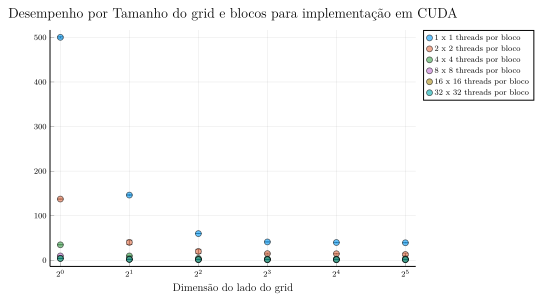

In [27]:
plot_results(cuda_triplespiral, cuda_triplespiral, "blocos", cuda_triplespiral, recursive = 1,
    title = "Desempenho por Tamanho do grid e blocos para implementação em CUDA",
    xaxis = "Dimensão do lado do grid", max_thread_power = 5, min_thread_power = 0)

Podemos ver que a implementação utilizando CUDA apresenta resultados muito variados de acordo com os parâmetros, obtendo com ela os melhores e piores tempos. Lembramos que a dimensão do lado do grid se refere ao valor n do grid de tamanho n x n, correspondente ao número de blocos por linha. É importante ressaltar que os intervalos de confiança estão sendo exibidos, porém devido à escala são difíceis de serem observados.

Observamos que para pequenos valores de dimensão do lado do grid há um tempo de execução muito alto até mesmo em relação à implementação sequencial (cerca de 20 vezes mais alto). Isso se dá pelo fato da GPU ser otimizada para realizar tarefas com menor carga de trabalho e maior paralelização, ao invés de poucas tarefas com alta carga de trabalho. Pelo mesmo motivo, para valores maiores da dimensão do lado do grid obtemos melhores resultados, chegando a aproximadamente 1.4 segundos nas suas melhores configurações.

Para visualizarmos melhor a relação entre dimensão do grid e blocos, desconsideramos os dois primeiros valores para a dimensão do lado do grid, obtendo o seguinte gráfico:

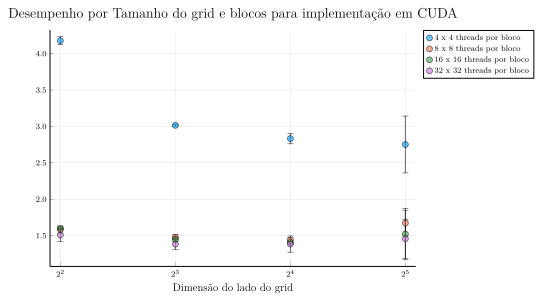

In [28]:
plot_results(filter(row -> row[:griddim] >= 4, cuda_triplespiral), cuda_triplespiral,
    "blocos", cuda_triplespiral, recursive = 1,
    title = "Desempenho por Tamanho do grid e blocos para implementação em CUDA",
    xaxis = "Dimensão do lado do grid", max_thread_power = 5, min_thread_power = 2)

Verificamos que para todos as dimensões do lado do grid, obtemos melhor tempo de execução com $32 \times 32$ threads por bloco. Observando o desempenho geral com o CUDA, podemos afirmar que com um grid de $8 \times 8$ e $16 \times 16$ blocos obtemos tempos ótimos praticamente indistinguíveis entre si. Para maior valor da dimensão do lado do grid, obtemos um desempenho com maior intervalo de confiança, ou seja, menor consistência no tempo de execução. Acreditamos que isso se dá devido ao manejamento de threads ociosas quando o grid é extenso.

## OMPI+OMP

In [29]:
show(ompi_omp_triplespiral, allrows=true)

36×8 DataFrame. Omitted printing of 3 columns
│ Row │ threads │ processes │ griddim │ blocos │ mean_duration │
│     │ Int64   │ Int64     │ Int64   │ Int64  │ Float64       │
├─────┼─────────┼───────────┼─────────┼────────┼───────────────┤
│ 1   │ 1       │ 2         │ 0       │ 0      │ 24.3381       │
│ 2   │ 2       │ 2         │ 0       │ 0      │ 14.6038       │
│ 3   │ 4       │ 2         │ 0       │ 0      │ 24.1539       │
│ 4   │ 8       │ 2         │ 0       │ 0      │ 12.6833       │
│ 5   │ 16      │ 2         │ 0       │ 0      │ 12.3079       │
│ 6   │ 32      │ 2         │ 0       │ 0      │ 12.0649       │
│ 7   │ 1       │ 4         │ 0       │ 0      │ 9.98489       │
│ 8   │ 2       │ 4         │ 0       │ 0      │ 13.2954       │
│ 9   │ 4       │ 4         │ 0       │ 0      │ 20.0052       │
│ 10  │ 8       │ 4         │ 0       │ 0      │ 10.2981       │
│ 11  │ 16      │ 4         │ 0       │ 0      │ 10.5274       │
│ 12  │ 32      │ 4         │ 0       │ 0   

Este experimento serve como um ótima demonstração do efeito que uma paralelização excessiva pode ter no desempenho do programa. Aqui, foram executados entre 2 e 64 processos com OMPI, cada um executando entre 1 e 32 threads por vez. Podemos ver que para 2 ou 4 processos temos resultados razoáveis, comparáveis à algumas das implementações anteriores, com o melhor tempo ocorrendo para 4 processos com 1 thread cada um, numa média de 9.98 segundos.

Entretanto, a partir de 8 processos, vemos um aumento significativo no tempo de execução, chegando a uma média de 273 segundos no pior caso, de 64 processos com 4 threads cada. Nele, toda essa paralelização sobrecarrega a CPU, fazendo com que ela gaste a maior parte do seu tempo manejando as interações entre os processos ao invés de realizando os cálculos que buscamos. Com isso, temos aqui desempenho pior que a implementação sequencial, num fator de mais de 10x neste pior caso.

Abaixo, no gráfico, essa piora de desempenho fica ainda mais evidente:

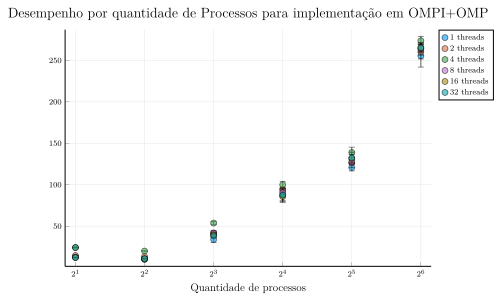

In [56]:
plot_results(ompi_omp_triplespiral, ompi_omp_triplespiral.mean_duration, "Triple Spiral", 
    ompi_omp_triplespiral.ci_duration,
    title = "Desempenho por quantidade de Processos para implementação em OMPI+OMP",
    xaxis = "Quantidade de processos", max_thread_power = 6, recursive = 1, ompi = 1, ompi2 = 1)

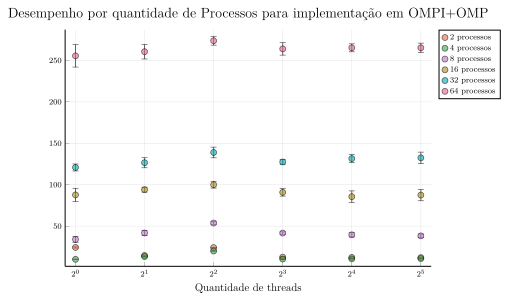

In [51]:
plot_results(ompi_omp_triplespiral, ompi_omp_triplespiral, "Triple Spiral", 
    ompi_omp_triplespiral,
    title = "Desempenho por quantidade de Processos para implementação em OMPI+OMP",
    xaxis = "Quantidade de threads", max_thread_power = 6, recursive = 1, ompi = 1)

Com o gráfico acima conseguimos verificar novamente que a quantidade de processos ideal para a implementação em OMPI está em torno de 2 e 4 processos.

# Conclusão geral

Com a realização desse exercício programa, observamos como a paralelização em geral melhora o desempenho do programa. Desta forma passamos de uma média de tempo de 23 segundos com a implementação sequencial para uma média de até 4.5 segundos com a implementação paralelizada em PThreads e em OpenMP. 

Neste EP em específico foram implementados os algoritmos de mandelbrot paralelizados com as ferramentas de OMPI, tanto por conta própria como com OMP, e CUDA, e verificamos que a utilização de GPU melhora consideravelmente o tempo de execução. Por análise de gráficos e tabelas, encontramos os melhores parâmetros para chegarmos a um tempo de execução ótimo. Os melhores resultados obtidos para as implementações são: uma média de 1.4 segundos para implementação em CUDA com dimensão do grid em $16 \times 16$ e $32 \times 32$ threads, uma média de 9.8 segundos em OMPI com $4$ processos. O tempo ótimo para a implementação de OMPI com OpenMP foi de 9.98 segundos, com $4$ processos com $1$ thread cada, virtualmente igual à implementação usando apenas OMPI.

O grande aumento de tempo do OMPI+OMP nos piores casos mostra como a paralelização deve ser utilizada de forma consciente para que ajude a melhorar o desempenho ao invés de tornar todo o programa mais lento. Já a grande diferença de desempenho, aqui positiva, ao se utilizar o CUDA mostra como uma otimização de hardware pode trazer muitos benefícios.